<a href="https://colab.research.google.com/github/khairulomar/Melbourne_pedestrian/blob/master/Melbourne_pedestrian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install sodapy

In [0]:
import pandas as pd
import numpy as np
import math
import warnings
warnings.filterwarnings("ignore")
import datetime as dt
import time
from datetime import datetime
from sodapy import Socrata
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Investigate overall data

In [3]:
# Import data from API

client = Socrata('data.melbourne.vic.gov.au',
                 'rU9dviaJKpt9U9Mk9aPFFOIvS',
                 'khairul@yahoo.com',
                 'KhairulMaps2019&')

# To begin, download all data but limit to only for monday noons for overview
results = client.get("b2ak-trbp", day='Monday', time=12, limit=50000)

dfraw0 = pd.DataFrame.from_records(results)
display(len(dfraw0))
display(dfraw0.head())

17822

,id,date_time,year,month,mdate,day,time,sensor_id,sensor_name,hourly_counts
0,2891212,2019-11-04T12:00:00.000,2019,November,4,Monday,12,4,Town Hall (West),4535
1,2891213,2019-11-04T12:00:00.000,2019,November,4,Monday,12,17,Collins Place (South),1145
2,2891214,2019-11-04T12:00:00.000,2019,November,4,Monday,12,18,Collins Place (North),421
3,2891215,2019-11-04T12:00:00.000,2019,November,4,Monday,12,53,Collins St (North),2570
4,2891216,2019-11-04T12:00:00.000,2019,November,4,Monday,12,2,Bourke Street Mall (South),5227


In [4]:
# First round of cleaning
df = dfraw0.copy()
df['date_time'] = pd.to_datetime(df['date_time'])
df['date'] = df['date_time'].dt.date
df['year'] = df['year'].astype('int')
df['hourly_counts'] = df['hourly_counts'].astype('int')
df['sensor'] = df['sensor_id'].map(lambda row: '0'+str(row) if int(row)<10 else row) + " : " + df['sensor_name']
df['sensor_id'] = df['sensor_id'].astype('int')
df.dtypes

id                       object
date_time        datetime64[ns]
year                      int64
month                    object
mdate                    object
day                      object
time                     object
sensor_id                 int64
sensor_name              object
hourly_counts             int64
date                     object
sensor                   object
dtype: object

In [5]:
# Convert to pivot for plotting
table = pd.pivot_table(df, values='hourly_counts', index='date',
                       columns='sensor', aggfunc=np.sum)
table.head(2)

sensor,01 : Bourke Street Mall (North),02 : Bourke Street Mall (South),03 : Melbourne Central,04 : Town Hall (West),05 : Princes Bridge,06 : Flinders Street Station Underpass,07 : Birrarung Marr,08 : Webb Bridge,09 : Southern Cross Station,10 : Victoria Point,11 : Waterfront City,12 : New Quay,13 : Flagstaff Station,14 : Sandridge Bridge,15 : State Library,16 : Australia on Collins,17 : Collins Place (South),18 : Collins Place (North),19 : Chinatown-Swanston St (North),20 : Chinatown-Lt Bourke St (South),21 : Bourke St-Russell St (West),22 : Flinders St-Elizabeth St (East),23 : Spencer St-Collins St (South),24 : Spencer St-Collins St (North),25 : Melbourne Convention Exhibition Centre,26 : QV Market-Elizabeth St (West),27 : QV Market-Peel St,28 : The Arts Centre,29 : St Kilda Rd-Alexandra Gardens,30 : Lonsdale St (South),31 : Lygon St (West),32 : City Square,33 : Flinders St-Spring St (West),34 : Flinders St-Spark La,35 : Southbank,36 : Queen St (West),37 : Lygon St (East),38 : Flinders St-Swanston St (West),39 : Alfred Place,40 : Lonsdale St-Spring St (West),41 : Flinders La-Swanston St (West),42 : Grattan St-Swanston St (West),43 : Monash Rd-Swanston St (West),44 : Tin Alley-Swanston St (West),45 : Little Collins St-Swanston St (East),46 : Pelham St (S),46 : Pelham St (South),47 : Melbourne Central-Elizabeth St (East),48 : QVM-Queen St (East),49 : QVM-Therry St (South),50 : Faraday St-Lygon St (West),51 : QVM-Franklin St (North),52 : Elizabeth St-Lonsdale St (South),53 : Collins St (North),54 : Lincoln-Swanston (West),54 : Lincoln-Swanston(West),55 : Elizabeth St-La Trobe St (East),56 : Lonsdale St - Elizabeth St (North),57 : Bourke St Bridge,58 : Bourke St - Spencer St (North),59 : Swanston St - RMIT Building 80,60 : Flinders La - Swanston St (West) Temp,60 : Flinders la - Swanston St (West) Temp,61 : Swanston St - RMIT Building 14,62 : La Trobe St (North),63 : 231 Bourke St,64 : Royal Pde-Grattan St
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-05-04,3532.0,2761.0,NaN,3789.0,1492.0,1931.0,NaN,NaN,808.0,529.0,93.0,267.0,1130.0,529.0,1829.0,2733.0,1442.0,722.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-05-11,3246.0,2483.0,NaN,3434.0,1269.0,1874.0,NaN,NaN,752.0,477.0,182.0,343.0,1097.0,602.0,1742.0,2552.0,1526.0,782.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


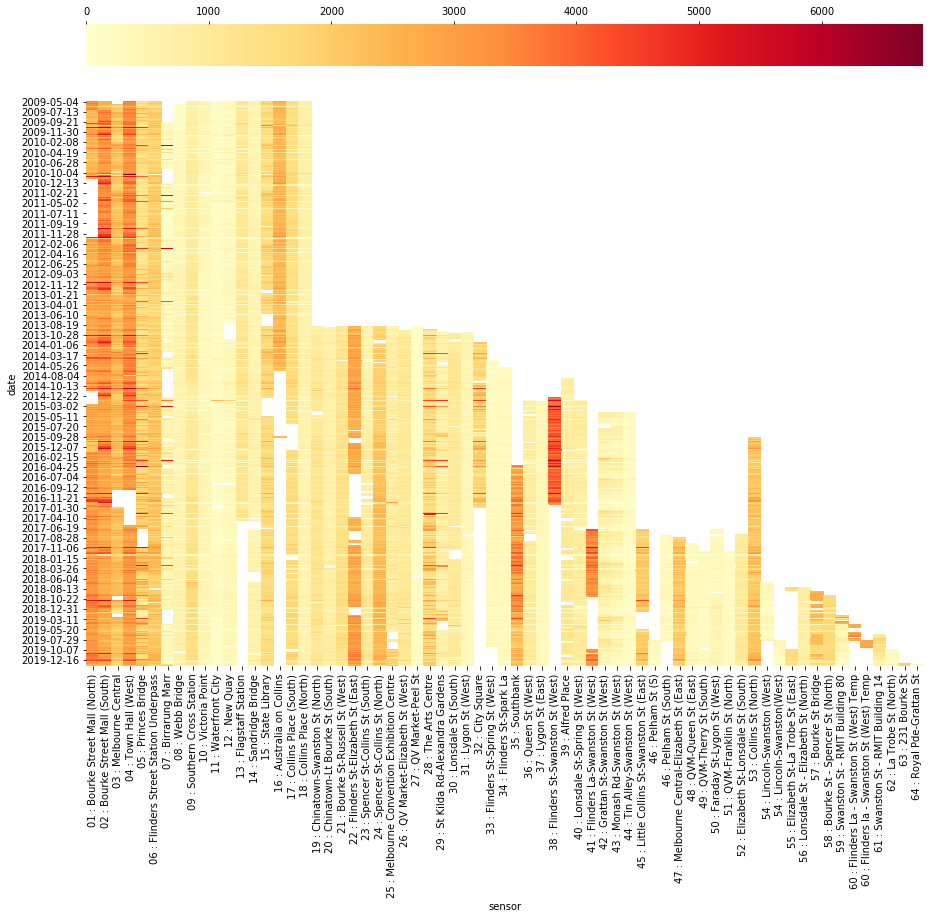

In [6]:
# Plot all available data, sampling at Monday noon only
fig, ax = plt.subplots(figsize=(15,13))
ax = sns.heatmap(table, cbar_kws = dict(use_gridspec=False,location="top"), cmap='YlOrRd')
plt.show()

# Shortlist sensor locations and period

In [7]:
# Group sensor locations based on availability of data

from google.colab import drive
drive.mount('/content/drive')

sensor_master = pd.read_excel('/content/drive/My Drive/Melb_project/CBD_grid.xlsx', sheet_name='master')
sensor_master = sensor_master.iloc[:,:8]
sensor_master.head()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


,sensor_id,sensor_description,installation_date,CBD,Train_data,Test_data,x,y
0,1,Bourke Street Mall (North),2009-03-24,1,1,1,NaN,NaN
1,2,Bourke Street Mall (South),2009-03-30,1,1,1,NaN,NaN
2,3,Melbourne Central,2009-03-25,1,1,1,NaN,NaN
3,4,Town Hall (West),2009-03-23,1,1,1,NaN,NaN
4,5,Princes Bridge,2009-03-26,1,1,1,NaN,NaN


In [8]:
# List of sensor for training and test data
sensors = list(sensor_master[sensor_master['CBD']==1].sensor_id)
sensors_train_test = list(sensor_master[sensor_master['Train_data']==1].sensor_id)
sensors_test = list(sensor_master[(sensor_master['Train_data']==0)&sensor_master['Test_data']==1].sensor_id)
len(sensors)

39

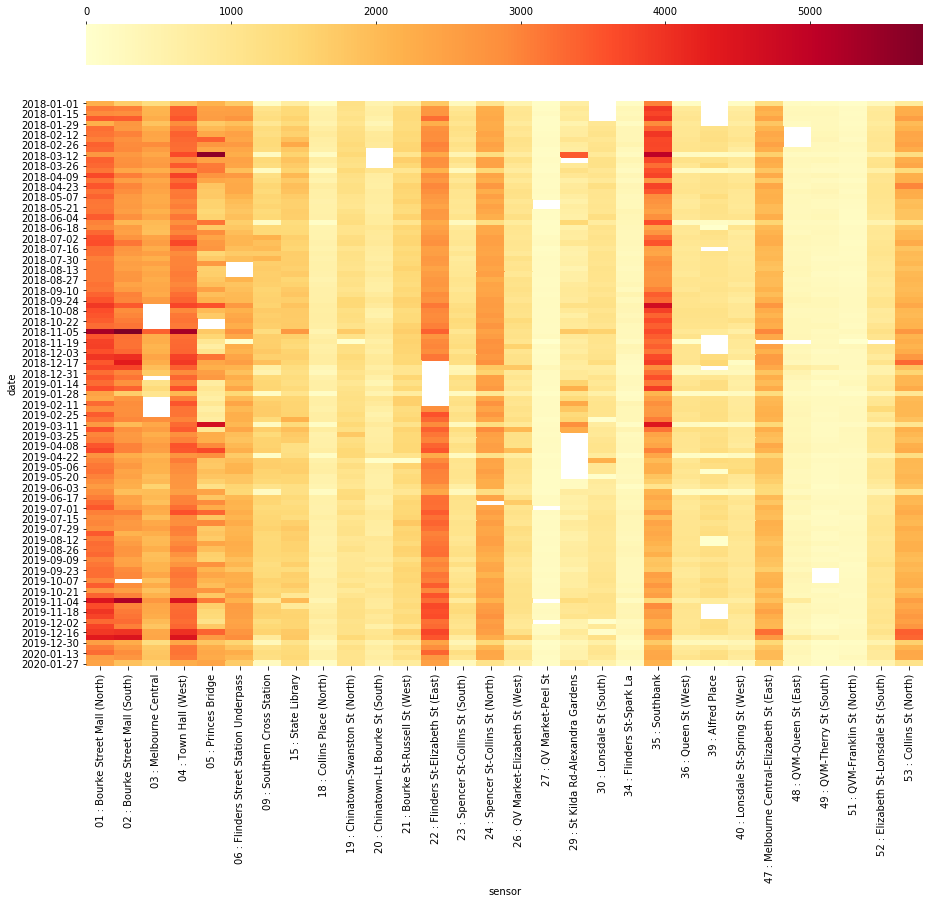

In [9]:
# Visualize training+test sensors for past 2 years
dftt = df[df['sensor_id'].isin(sensors_train_test)]
dfplot2 = dftt[dftt['year'] >= 2018][['date','sensor','hourly_counts']]

table2 = pd.pivot_table(dfplot2, values='hourly_counts', index='date',
                       columns='sensor', aggfunc=np.sum)

fig, ax = plt.subplots(figsize=(15,13))
ax = sns.heatmap(table2, cbar_kws = dict(use_gridspec=False,location="top"), cmap='YlOrRd')
plt.show()

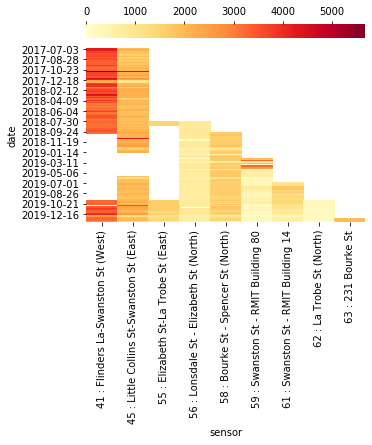

In [10]:
# Visualize test sensors only
dfts = df[df['sensor_id'].isin(sensors_test)]
table3 = pd.pivot_table(dfts, values='hourly_counts', index='date',
                       columns='sensor', aggfunc=np.sum)

fig, ax = plt.subplots(figsize=(5,4))
ax = sns.heatmap(table3, cbar_kws = dict(use_gridspec=False,location="top"), cmap='YlOrRd')
plt.show()

In [0]:
# Download all data for shortlisted sensor for last 2 years

# pbar  = progressbar.ProgressBar()
# dfraw = pd.DataFrame(columns=dfraw0.columns)
# years = [2018, 2019, 2020]

# for year in years:
#     for sensor in sensors:
#         results = client.get("b2ak-trbp", sensor_id=sensor, year=year, limit=10000)
#         dfitem = pd.DataFrame.from_records(results)
#         dfraw = pd.concat([dfraw, dfitem])
# dfraw.to_csv('/content/drive/My Drive/Melb_project/sensors_data.csv')
# len(dfraw)

In [0]:
# Open from saved API
dfraw = pd.read_csv('/content/drive/My Drive/Melb_project/sensors_data.csv')
dfraw = dfraw.drop('Unnamed: 0', axis=1)

In [13]:
# Check if no missing datastamps 
a = len(dfraw.date_time.unique())
b = 2*365*24 + 31*24 # num of hours from 01-01-2018 to 31-01-2020
c = sorted(dfraw.date_time.unique())[-1]
print(f'Latest available timestamp in data: {c}')
print(f'Number of unique timestamps in data: {a}')
print(f'Number of expected timestamps: {b}')
print(f'Missing timestamps: {b-a}')

Latest available timestamp in data: 2020-01-31T23:00:00.000
Number of unique timestamps in data: 18264
Number of expected timestamps: 18264
Missing timestamps: 0


# Deal with missing (null) records

In [14]:
# Reshape df into pivot for filling nulls
df0 = dfraw[dfraw['sensor_id'].isin(sensors_train_test)] # exclude test-only sites
df0 = pd.pivot_table(df0, columns='sensor_id',
                     values='hourly_counts',
                     index=['date_time'],
                     aggfunc=np.sum)
display(df0.shape)
display(df0.head(3))

(18264, 30)

sensor_id,1,2,3,4,5,6,9,15,18,19,20,21,22,23,24,26,27,29,30,34,35,36,39,40,47,48,49,51,52,53
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01T00:00:00.000,895.0,734.0,2996.0,3052.0,1757.0,3443.0,1411.0,1709.0,326.0,605.0,431.0,1938.0,2317.0,540.0,1459.0,571.0,181.0,0.0,NaN,943.0,5724.0,685.0,NaN,607.0,1542.0,223.0,264.0,390.0,493.0,1129.0
2018-01-01T01:00:00.000,890.0,590.0,3481.0,3204.0,3900.0,3579.0,436.0,1511.0,118.0,813.0,472.0,2035.0,2158.0,376.0,1426.0,529.0,137.0,814.0,NaN,394.0,5168.0,604.0,NaN,110.0,1227.0,201.0,215.0,134.0,541.0,626.0
2018-01-01T02:00:00.000,435.0,317.0,1721.0,2042.0,2012.0,3157.0,222.0,666.0,64.0,473.0,401.0,1169.0,1305.0,219.0,797.0,286.0,69.0,576.0,NaN,148.0,2495.0,309.0,NaN,65.0,684.0,87.0,116.0,83.0,373.0,226.0


In [15]:
# Check the extent of nan values.
# Total records per sensor_id = 18,284
df0.isna().sum()

sensor_id
1      144
2      240
3     1570
4        0
5      264
6      433
9        0
15       0
18       0
19       0
20     792
21       0
22    1512
23       0
24      72
26      48
27     672
29    1634
30     600
34       0
35       0
36       0
39    2286
40       0
47     108
48     708
49     408
51       0
52     121
53       0
dtype: int64

In [0]:
# Since hourly traffic is very cyclical, copy value from
# the same time and the same day a week ago.

# Number of hours in a week
week_hrs = 7*24

for site in df0.columns:
    for row in range(len(df0.index)):
      # check if hourly record is null
        if math.isnan(df0[site].iloc[row]):
          # if so, copy from the same hour from a week ago
            if row - week_hrs > 0:
                df0[site].iloc[row] = df0[site].iloc[row - week_hrs]
            else:
                # if missing at start of the record:
                df0[site].iloc[row] = df0[site].iloc[row + week_hrs*6]

In [17]:
# Double check no nulls left
(df0.isna().sum()).sum()

0

In [18]:
# Unstack pivot to double check and prepare to build other columns

df0 = pd.DataFrame(df0.stack())
df0 = df0.rename(columns={0:'hourly_counts'})
df0 = df0.reset_index()
print(f'Number of complete timestamps: {b}')
print(f'Number of df rows: {len(df0)}')
print(f'Number df rows / timestamps = num of sites: {len(df0)/b}')
display(df0.head())

Number of complete timestamps: 18264
Number of df rows: 547920
Number df rows / timestamps = num of sites: 30.0


,date_time,sensor_id,hourly_counts
0,2018-01-01T00:00:00.000,1,895.0
1,2018-01-01T00:00:00.000,2,734.0
2,2018-01-01T00:00:00.000,3,2996.0
3,2018-01-01T00:00:00.000,4,3052.0
4,2018-01-01T00:00:00.000,5,1757.0


In [19]:
# Build complete data frame
df = df0.copy()
df['date_time'] = pd.to_datetime(df['date_time']) # format='%Y-%m-%d %H:%M:%S'
df['time']      = df['date_time'].dt.hour
df['mdate']     = df['date_time'].dt.day
df['day']       = df['date_time'].dt.dayofweek
df['week']      = df['date_time'].dt.weekofyear
df['month']     = df['date_time'].dt.month
df['year']      = df['date_time'].dt.year
df['hourly_counts'] = df['hourly_counts'].astype('int')

names_table = sensor_master[['sensor_id', 'sensor_description']].set_index('sensor_id')
names_table = names_table.rename(columns={'sensor_description':'sensor_name'})
df = df.join(names_table, on='sensor_id')
df['sensor'] = (df['sensor_id'].map(lambda row: '0'+str(row)\
                                    if int(row)<10 else row)).astype('str')\
                                     + " : " + df['sensor_name']
display(len(df))
display(sorted(df.date_time.unique())[-1])
display(df.head(3))
display(df.dtypes)

547920

numpy.datetime64('2020-01-31T23:00:00.000000000')

,date_time,sensor_id,hourly_counts,time,mdate,day,week,month,year,sensor_name,sensor
0,2018-01-01,1,895,0,1,0,1,1,2018,Bourke Street Mall (North),01 : Bourke Street Mall (North)
1,2018-01-01,2,734,0,1,0,1,1,2018,Bourke Street Mall (South),02 : Bourke Street Mall (South)
2,2018-01-01,3,2996,0,1,0,1,1,2018,Melbourne Central,03 : Melbourne Central


date_time        datetime64[ns]
sensor_id                 int64
hourly_counts             int64
time                      int64
mdate                     int64
day                       int64
week                      int64
month                     int64
year                      int64
sensor_name              object
sensor                   object
dtype: object

# Investigate variations by location

## 1. Variation by traffic volume

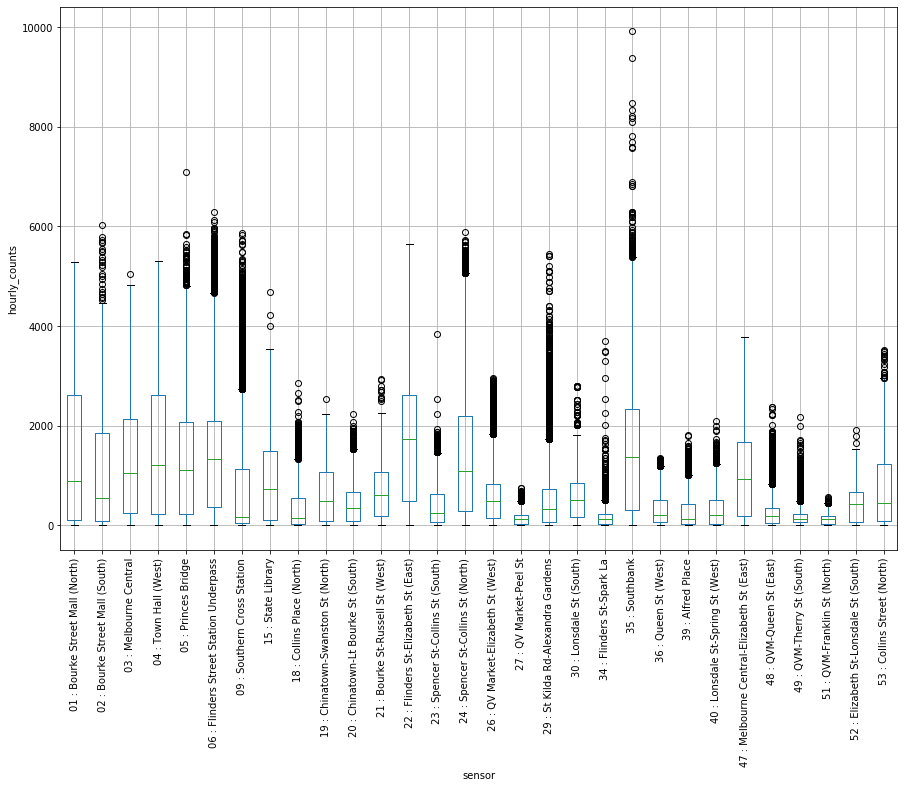

In [20]:
pivotvolume = pd.pivot_table(df, values='hourly_counts',
                             index='date_time', columns='sensor',
                             aggfunc=np.mean)
fig, ax = plt.subplots(figsize=(15,10))
pivotvolume.boxplot(ax=ax)
plt.xticks(rotation=90)
ax.set_xlabel('sensor')
ax.set_ylabel('hourly_counts')
plt.show()

### 2. Variation by hour

In [0]:
# Prepare data for hourly variation
weekdays = df[df['day'] < 5]
weekends = df[df['day'] > 4]

# Part 1
# Normalize data for each sensor
# Weekdays:
pivothour = pd.pivot_table(weekdays, values='hourly_counts',
                           index='time', columns='sensor_id',
                           aggfunc=np.nanmean)
hourcols = pivothour.columns
pivothour = preprocessing.normalize(pivothour, norm='l1', axis=0)
dfhour = pd.DataFrame(pivothour, index=range(0,24), columns=hourcols)
# Weekends:
pivothourW = pd.pivot_table(weekends, values='hourly_counts',
                           index='time', columns='sensor_id',
                           aggfunc=np.nanmean)
hourcolsW = pivothourW.columns
pivothourW = preprocessing.normalize(pivothourW, norm='l1', axis=0)
dfhourW = pd.DataFrame(pivothourW, index=range(0,24), columns=hourcols)

# Part 2
# Normalize data for avg of all sensors
# Weekdays:
pivothour2 = pd.pivot_table(weekdays, values='hourly_counts',
                            index='time', aggfunc=np.nanmean)
dfhour2 = preprocessing.normalize(pivothour2, norm='l1', axis=0)
dfhour2 = pd.DataFrame(dfhour2, index=range(0,24), columns=['all_sensors'])
# Weekends:
pivothour2W = pd.pivot_table(weekends, values='hourly_counts',
                            index='time', aggfunc=np.nanmean)
dfhour2W = preprocessing.normalize(pivothour2W, norm='l1', axis=0)
dfhour2W = pd.DataFrame(dfhour2W, index=range(0,24), columns=['all_sensors'])
# Each of the 7 days
pivothour2E = pd.pivot_table(df, values='hourly_counts', columns='day',
                            index='time', aggfunc=np.nanmean)
dfhour2E = preprocessing.normalize(pivothour2E, norm='l1', axis=0)
dfhour2E = pd.DataFrame(dfhour2E, index=range(0,24), columns=range(0,7))

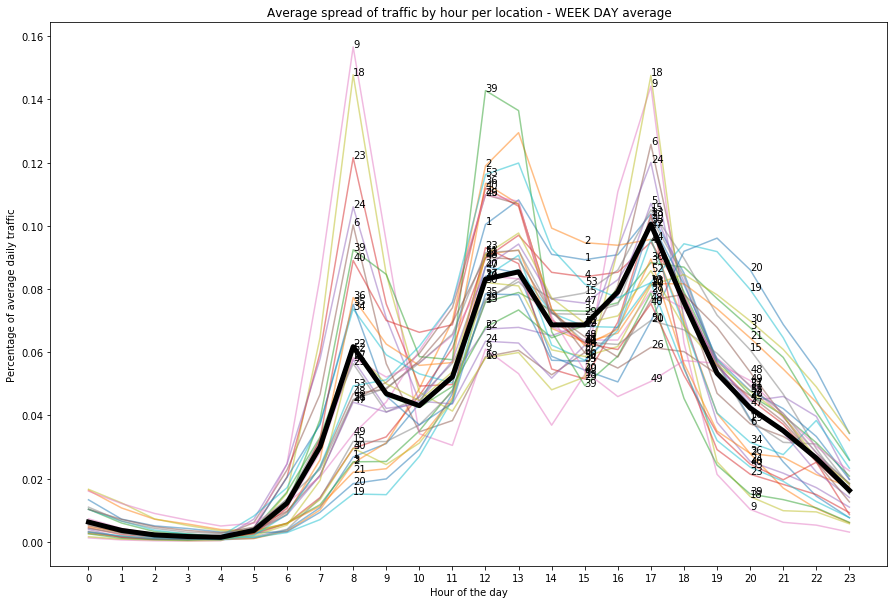

In [22]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(dfhour, alpha=0.5)
ax.plot(dfhour2, linewidth=5, c='black')

for hour in [8,12,15,17,20]:
    labels = zip(dfhour[dfhour.index == hour].values[0], dfhour.columns)
    for y, label in labels:
        plt.text(hour, y, label, fontsize=10)

ax.set_title('Average spread of traffic by hour per location - WEEK DAY average')
ax.set_ylabel('Percentage of average daily traffic')
ax.set_xlabel('Hour of the day')
ax.set_xticks(range(0,24))
plt.show()

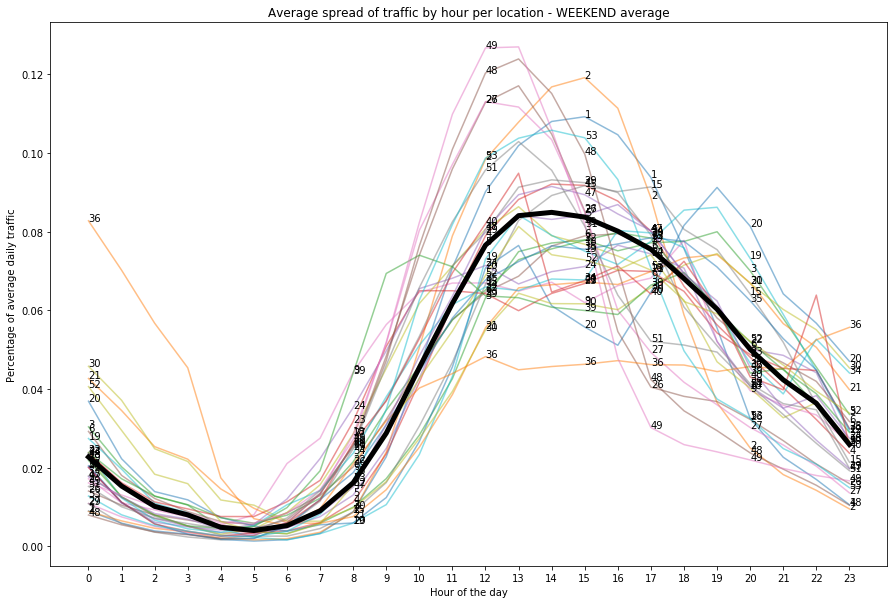

In [23]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(dfhourW, alpha=0.5)
ax.plot(dfhour2W, linewidth=5, c='black')

for hour in [0,8,12,15,17,20,23]:
    labels = zip(dfhourW[dfhourW.index == hour].values[0], dfhourW.columns)
    for y, label in labels:
        plt.text(hour, y, label, fontsize=10)

ax.set_title('Average spread of traffic by hour per location - WEEKEND average')
ax.set_ylabel('Percentage of average daily traffic')
ax.set_xlabel('Hour of the day')
ax.set_xticks(range(0,24))
plt.show()

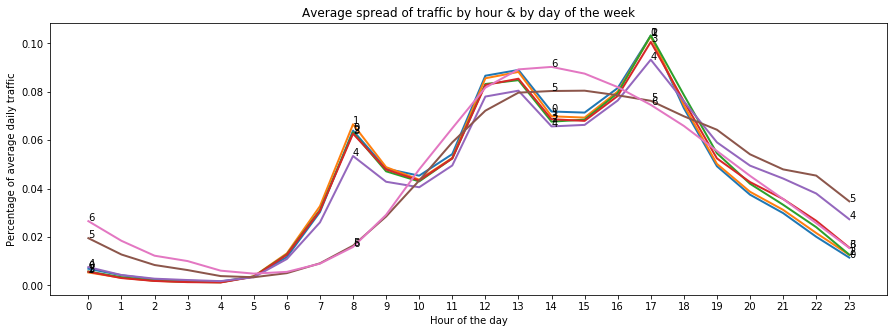

In [24]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(dfhour2E, linewidth=2)

for hour in [0,8,14,17,23]:
    labels = zip(dfhour2E[dfhour2E.index == hour].values[0], dfhour2E.columns)
    for y, label in labels:
        plt.text(hour, y, label, fontsize=10)

ax.set_title('Average spread of traffic by hour & by day of the week')
ax.set_ylabel('Percentage of average daily traffic')
ax.set_xlabel('Hour of the day')
ax.set_xticks(range(0,24))
plt.show()

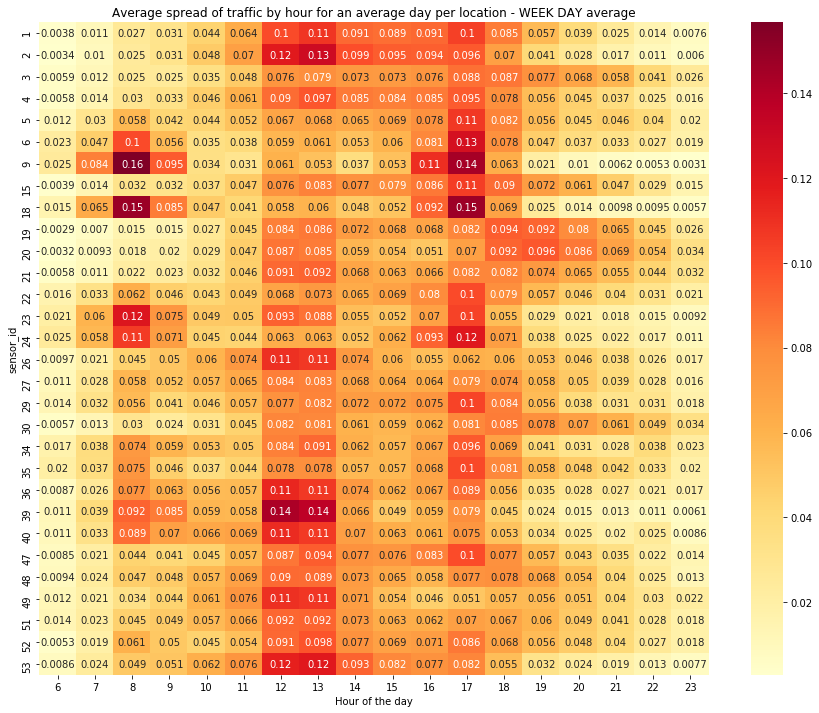

In [25]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(dfhour[dfhour.index > 5].T, ax=ax, cmap='YlOrRd', annot=True)
ax.set_title('Average spread of traffic by hour for an average day per location - WEEK DAY average')
ax.set_xlabel('Hour of the day')
plt.show()

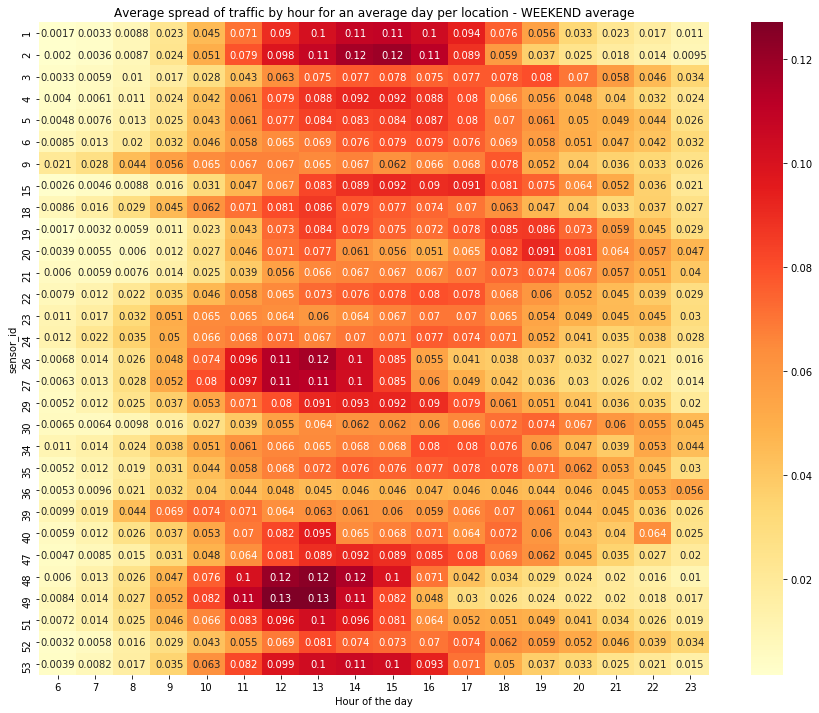

In [26]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(dfhourW[dfhourW.index > 5].T, ax=ax, cmap='YlOrRd', annot=True)
ax.set_title('Average spread of traffic by hour for an average day per location - WEEKEND average')
ax.set_xlabel('Hour of the day')
plt.show()

#### 3. Variation by week day

In [0]:
# Normalize data for each sensor
pivotweek = pd.pivot_table(df, values='hourly_counts',
                           index='day', columns='sensor_id',
                           aggfunc=np.nanmean)
weekcols = pivotweek.columns
pivotweek = preprocessing.normalize(pivotweek, norm='l1', axis=0)
dfweek = pd.DataFrame(pivotweek, index=range(0,7), columns=weekcols)

# Normalize data for avg of all sensors
pivotweek2 = pd.pivot_table(df, values='hourly_counts',
                            index='day', aggfunc=np.nanmean)
dfweek2 = preprocessing.normalize(pivotweek2, norm='l1', axis=0)
dfweek2 = pd.DataFrame(dfweek2, index=range(0,7), columns=['all_sensors'])

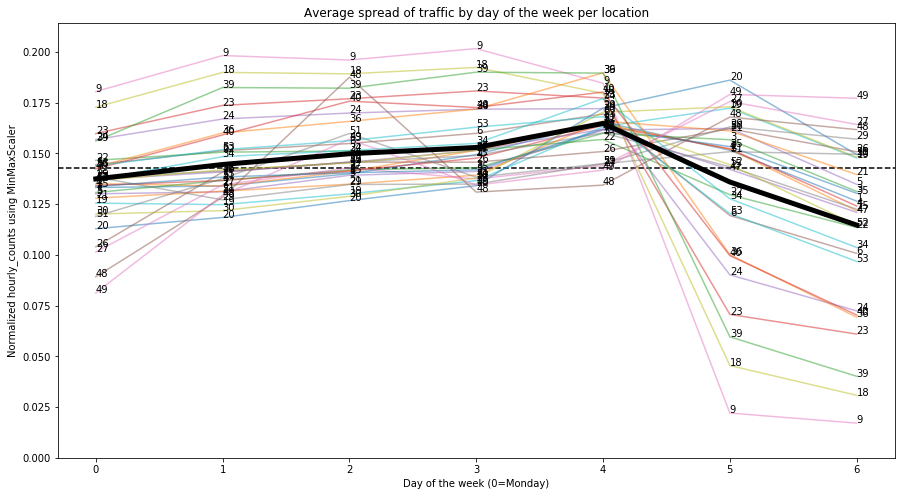

In [28]:
fig, ax = plt.subplots(figsize=(15,8))

ax.hlines(1/7,-0.3,6.3,linestyles='dashed') # if equal spread
ax.plot(dfweek, alpha=0.5) # actual spread
ax.plot(dfweek2, linewidth=5, c='black')

for day in range(0,7):
    labels = zip(dfweek[dfweek.index == day].values[0], dfweek.columns)
    for y, label in labels:
        plt.text(day, y, label, fontsize=10)

ax.set_title('Average spread of traffic by day of the week per location')
ax.set_ylabel('Normalized hourly_counts using MinMaxScaler')
ax.set_ylim(0,1.5/7)
ax.set_xlim(-0.3,6.3)
ax.set_xlabel('Day of the week (0=Monday)')
plt.show()

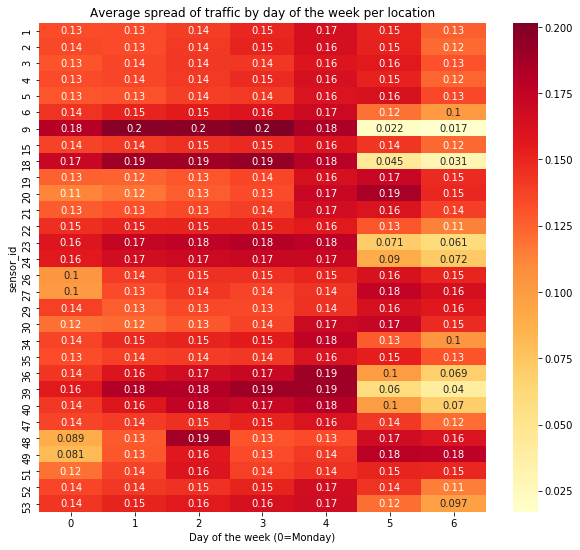

In [29]:
fig, ax = plt.subplots(figsize=(10,9))
sns.heatmap(dfweek.T, ax=ax, cmap='YlOrRd', annot=True)
ax.set_title('Average spread of traffic by day of the week per location')
ax.set_xlabel('Day of the week (0=Monday)')
plt.show()

### 4. Seasonal variation

In [0]:
# Normalize data by sensor
pivotseason = pd.pivot_table(df, values='hourly_counts',
                             index='week', columns='sensor_id',
                             aggfunc=np.nanmean)

nullcols = list((pivotseason.loc[:, pivotseason.isnull().any()]).columns)
dfseason = pivotseason = pivotseason.loc[:, pivotseason.columns.difference(nullcols)]
seasoncols = dfseason.columns
dfseason = preprocessing.normalize(dfseason, norm='l1', axis=0)
dfseason = pd.DataFrame(dfseason, index=range(0,52), columns=seasoncols)

# Normalize data for avg of all sensors
pivotseason2 = pd.pivot_table(df, values='hourly_counts',
                             index='week', aggfunc=np.nanmean)
dfseason2 = preprocessing.normalize(pivotseason2, norm='l1', axis=0)
dfseason2 = pd.DataFrame(dfseason2, index=range(0,52), columns=['all_sensors'])

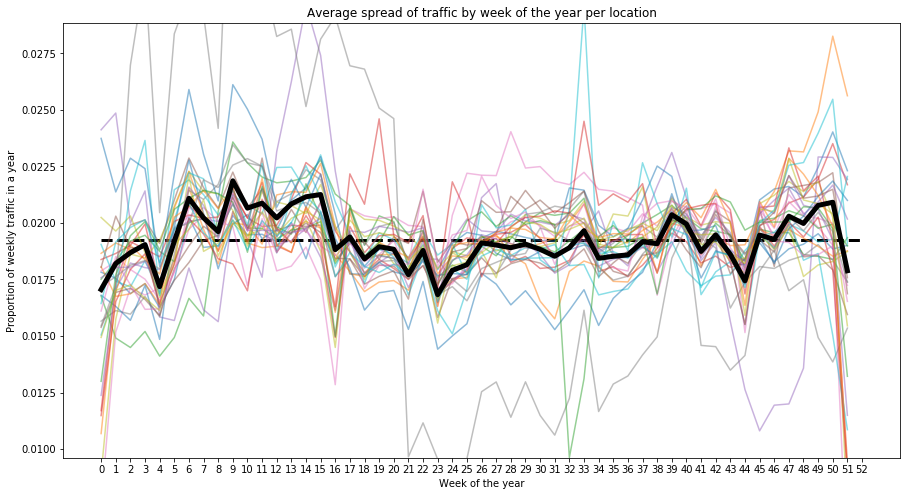

In [31]:
fig, ax = plt.subplots(figsize=(15,8))

ax.hlines(1/52,0,52,linestyles='dashed', linewidth=3) # if equal spread
ax.plot(dfseason, alpha=0.5)
ax.plot(dfseason2, linewidth=5, c='black')

ax.set_title('Average spread of traffic by week of the year per location')
ax.set_ylim(0.5/52,1.5/52)
ax.set_ylabel('Proportion of weekly traffic in a year')
ax.set_xlabel('Week of the year')
ax.set_xticks(range(0,53))
plt.show()

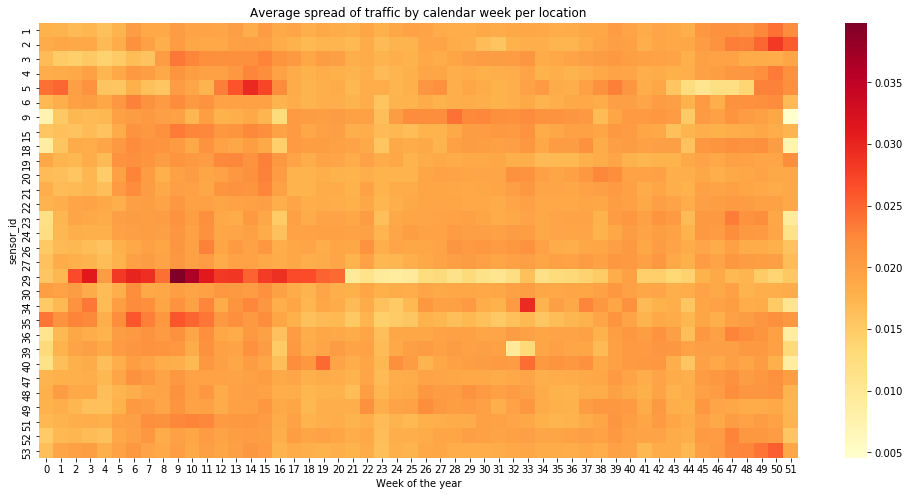

In [32]:
fig, ax = plt.subplots(figsize=(17,8))
sns.heatmap(dfseason.T, ax=ax, cmap='YlOrRd', annot=False)
ax.set_title('Average spread of traffic by calendar week per location')
ax.set_xlabel('Week of the year')
plt.show()

# Assign sites to groups

In [33]:
# Transform df to pivot such that columns are
# all possible combinations of day of week & time of day
pivotpca = pd.pivot_table(df, values='hourly_counts', index='sensor_id',
                          columns=['day','time'], aggfunc=np.mean)
sensor_id = pivotpca.index
# Normalize such that the sum of traffic in 7 days x 24 hours = 1
pivotpca = preprocessing.normalize(pivotpca, norm='l1', axis=1)
pivotpca = pd.DataFrame(pivotpca, index=sensor_id)
pivotpca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167
sensor_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.000404,0.000266,0.000130,0.000105,0.000087,0.000164,0.000499,0.001445,0.003635,0.004319,0.006272,0.009111,0.014357,0.015400,0.012993,0.012618,0.012499,0.013607,0.010574,0.006435,0.003678,0.002466,0.001424,0.000714,0.000358,0.000225,0.000119,0.000086,0.000069,0.000160,0.000552,0.001599,0.003925,0.004278,0.005887,0.008646,0.014094,0.015245,0.012656,0.012429,...,0.001523,0.003531,0.006830,0.010522,0.013129,0.014807,0.015649,0.016009,0.015571,0.014243,0.011674,0.009247,0.005539,0.003925,0.003278,0.002165,0.001351,0.000908,0.000613,0.000511,0.000290,0.000205,0.000230,0.000391,0.000930,0.002803,0.005815,0.009177,0.011942,0.013525,0.014383,0.014358,0.013520,0.011833,0.009364,0.006186,0.003510,0.002380,0.001457,0.000784
2,0.000374,0.000228,0.000136,0.000115,0.000121,0.000139,0.000453,0.001327,0.003301,0.004340,0.007152,0.010205,0.017364,0.018520,0.014174,0.013372,0.012859,0.012245,0.008441,0.004215,0.002608,0.001782,0.001079,0.000526,0.000337,0.000195,0.000118,0.000099,0.000105,0.000145,0.000514,0.001521,0.003722,0.004282,0.006488,0.009409,0.016672,0.018258,0.013769,0.013041,...,0.001435,0.003893,0.007683,0.011884,0.014627,0.015831,0.017067,0.017678,0.016741,0.013728,0.009366,0.006008,0.004118,0.003154,0.002754,0.001968,0.001367,0.001021,0.000726,0.000574,0.000334,0.000242,0.000252,0.000410,0.000943,0.002674,0.006153,0.009734,0.012326,0.013702,0.014917,0.014952,0.013758,0.010527,0.006749,0.004000,0.002739,0.001848,0.001152,0.000644
3,0.001542,0.000915,0.000481,0.000358,0.000254,0.000375,0.000749,0.001589,0.003488,0.003548,0.004881,0.006693,0.010547,0.010963,0.010255,0.010125,0.010260,0.011706,0.011037,0.009978,0.008324,0.006291,0.004094,0.002269,0.001167,0.000579,0.000314,0.000253,0.000178,0.000376,0.000851,0.001753,0.003670,0.003598,0.004856,0.006742,0.010811,0.011136,0.010406,0.010374,...,0.001551,0.002617,0.004257,0.006495,0.009275,0.011052,0.011452,0.011773,0.011441,0.011806,0.012066,0.012963,0.011847,0.010276,0.008594,0.006972,0.004621,0.003143,0.002055,0.001698,0.000785,0.000543,0.000466,0.000767,0.001322,0.002345,0.003893,0.005786,0.008924,0.010526,0.010759,0.010663,0.010198,0.010423,0.010259,0.010071,0.008327,0.006413,0.004533,0.002694
4,0.000997,0.000640,0.000356,0.000282,0.000239,0.000377,0.000739,0.001883,0.004025,0.004629,0.006651,0.008769,0.012903,0.013861,0.012163,0.011825,0.011630,0.012616,0.009696,0.006859,0.005199,0.004035,0.002515,0.001322,0.000676,0.000392,0.000211,0.000159,0.000172,0.000345,0.000856,0.002057,0.004352,0.004672,0.006381,0.008481,0.012752,0.013718,0.011966,0.011798,...,0.001778,0.003689,0.006329,0.009202,0.011587,0.012884,0.013422,0.013564,0.013138,0.012256,0.010220,0.008913,0.007809,0.006930,0.006044,0.004907,0.003455,0.002418,0.001609,0.001207,0.000674,0.000565,0.000656,0.000816,0.001336,0.002812,0.005191,0.007787,0.010234,0.011489,0.012030,0.011797,0.011121,0.009891,0.008057,0.006649,0.005483,0.004234,0.002873,0.001645
5,0.000883,0.000528,0.000292,0.000251,0.000300,0.000557,0.001583,0.004057,0.007981,0.005784,0.006574,0.007226,0.009611,0.009707,0.009489,0.009393,0.010485,0.014158,0.009849,0.006119,0.005283,0.004950,0.003361,0.001644,0.000654,0.000439,0.000266,0.000228,0.000266,0.000582,0.001842,0.004429,0.008507,0.005876,0.005613,0.006670,0.008755,0.009041,0.008450,0.008967,...,0.001978,0.003782,0.006057,0.008959,0.011388,0.012656,0.012036,0.012845,0.013906,0.013248,0.012187,0.011178,0.009011,0.009409,0.009430,0.005907,0.003238,0.001818,0.001192,0.000914,0.000615,0.000508,0.000817,0.001177,0.001905,0.003620,0.006662,0.009286,0.011451,0.012337,0.012660,0.012174,0.011909,0.010532,0.008459,0.006992,0.005873,0.005022,0.003687,0.001894


[0.43087706 0.18982777 0.16061907 0.09539566 0.03471353]
87.7% of variance explained after 3 PCA


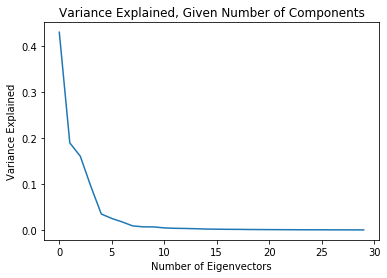

In [34]:
# Run PCA to help identify underlying traffic patterns per site

dfpca = StandardScaler().fit_transform(pivotpca)
fit = PCA()
pca = fit.fit_transform(dfpca)
plt.plot(fit.explained_variance_ratio_)
plt.title("Variance Explained, Given Number of Components")
plt.xlabel("Number of Eigenvectors")
plt.ylabel("Variance Explained")
k=4
print(fit.explained_variance_ratio_[:5])
print(f'{round(fit.explained_variance_ratio_[:k].sum()*100,1)}% of variance explained after {3} PCA')

In [0]:
# Start building table from pca for plotting
dfpca = pd.DataFrame(pca[:, :4], index=pivotpca.index, columns=['pca1','pca2','pca3','pca4'])

# Append average hourly traffic per site
pivotavg = pd.pivot_table(df, values='hourly_counts', index='sensor_id', aggfunc=np.mean)
dfpca = dfpca.join(pivotavg, on='sensor_id')

# Append proportion of weekend traffic per site
pivotwkd = pd.pivot_table(df, values='hourly_counts', index='sensor_id', columns='day', aggfunc=np.mean)
pivotwkd['wkend_share'] = pivotwkd.iloc[:, -2:].sum(axis=1) / pivotwkd.iloc[:, :].sum(axis=1)
pivotwkd = pivotwkd['wkend_share']
dfpca = dfpca.join(pivotwkd, on='sensor_id')

# Append site names
dfpca = dfpca.join(names_table, on='sensor_id')
dfpca['sensor'] = (dfpca.index.map(lambda row: '0'+str(row)\
                                    if int(row)<10 else row)).astype('str')\
                                     + " : " + dfpca['sensor_name']

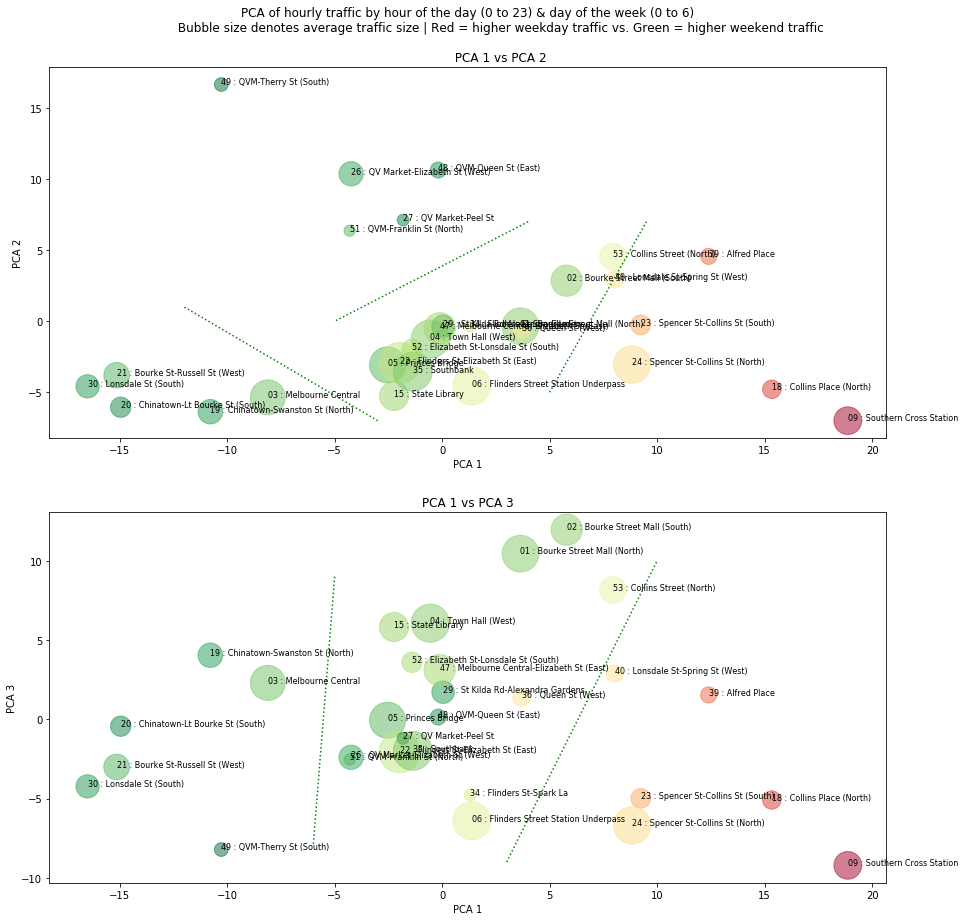

In [36]:
# Scatter plot to identify possible groupings of sites
fig, ax = plt.subplots(figsize=(15,15), ncols=1, nrows=2)
ax[0].set_title('PCA of hourly traffic by hour of the day (0 to 23) & day of the week (0 to 6)\n\
                 Bubble size denotes average traffic size | Red = higher weekday traffic vs. Green = higher weekend traffic\n\n\
                 PCA 1 vs PCA 2')
ax[1].set_title('PCA 1 vs PCA 3')

# Plot PCA 1 vs PCA 2
pcamap1 = ax[0].scatter(dfpca.pca1, dfpca.pca2, s=dfpca.hourly_counts,
                        c=dfpca.wkend_share, cmap='RdYlGn', alpha=0.5)
for i in range(len(dfpca.index)):
  ax[0].text(dfpca.iloc[i].pca1, dfpca.iloc[i].pca2, dfpca.iloc[i].sensor, fontsize=8)

# Plot PCA 1 vs PCA 3
pcamap2 = ax[1].scatter(dfpca.pca1, dfpca.pca3, s=dfpca.hourly_counts,
                        c=dfpca.wkend_share, cmap='RdYlGn', alpha=0.5)
for i in range(len(dfpca.index)):
  ax[1].text(dfpca.iloc[i].pca1, dfpca.iloc[i].pca3, dfpca.iloc[i].sensor, fontsize=8)

ax[0].set_xlabel('PCA 1')
ax[0].set_ylabel('PCA 2')
ax[1].set_xlabel('PCA 1')
ax[1].set_ylabel('PCA 3')
#fig.colorbar(pcamap1, orientation='horizontal', pad=0.05, shrink=0.3, ax=ax[1])

# Plot estimated grouping boundary for PCA 1 vs PCA 3
ax[0].plot((5,9.5), (-5,7), ls=':', c='g')
ax[0].plot((4,-5), (7,0), ls=':', c='g')
ax[0].plot((-3,-12), (-7,1), ls=':', c='g')

# Plot estimated grouping boundary for PCA 1 vs PCA 3
ax[1].plot((-5,-6), (9,-8), ls=':', c='g')
ax[1].plot((3,10), (-9,10), ls=':', c='g')

plt.show()

In [37]:
# Visualize in 3D to get a full 3-way relationship
import plotly.graph_objects as go
fig = go.Figure(data=go.Scatter3d(x=dfpca.pca1, y=dfpca.pca2,z=dfpca.pca3,
      text=dfpca.sensor, mode='markers', marker=dict(sizeref=20, size=dfpca.hourly_counts,
      color = dfpca.wkend_share, colorscale = 'RdYlGn')))
fig.update_layout(height=600, width=800, scene = dict(xaxis=dict(title='PCA 1'),
                  yaxis=dict(title='PCA 2'), zaxis=dict(title='PCA 3')))
fig.show()

In [0]:
# Identify number of groups
group_name = {1: 'Mixed-use sites',
              2: 'Business sites',
              3: 'Leisure sites'}

# Assign each site ID to a group
# in format {sensor_ID:group_name}
grouped_site = { 1:1,  2:1,  3:1,  4:1,  5:1,  6:1,  9:2, 15:1, 18:2, 19:1,
                20:1, 21:1, 22:1, 23:2, 24:2, 26:3, 27:3, 29:1, 30:1, 34:1,
                35:1, 36:1, 39:2, 40:2, 47:1, 48:3, 49:3, 51:3, 52:1, 53:1}

df['group'] = df['sensor_id'].map(grouped_site)

In [0]:
weekdays = [0,1,2,3,4]
weekends = [5,6]
groups   = [1,2,3]

# Prepare data to plot hourly variation by group:
hour_data_list = []
for days in [weekdays, weekends]:
  for group in groups:
    data = df[(df['day'].isin(days)) & (df['group']==group)]
    # For individual sites in that group:
    sites = pd.pivot_table(data, values='hourly_counts',
                           index='time', columns='sensor_id',
                           aggfunc=np.nanmean)
    cols = sites.columns
    sites = preprocessing.normalize(sites, norm='l1', axis=0)
    hour_data_sites = pd.DataFrame(sites, index=range(0,24), columns=cols)
    # For total sites in that group:
    total = pd.pivot_table(data, values='hourly_counts',
                           index='time',
                           aggfunc=np.nanmean)
    cols = ['all_sensors']
    total = preprocessing.normalize(total, norm='l1', axis=0)
    hour_data_total = pd.DataFrame(total, index=range(0,24), columns=cols)
    # Combine
    hour_data_list.append((hour_data_sites, hour_data_total, group, days))

# Prepare data to plot day of the week variation by group:
day_data_list = []
for group in groups:
    data = df[df['group']==group]
    # For individual sites in that group:
    sites = pd.pivot_table(data, values='hourly_counts',
                           index='day', columns='sensor_id',
                           aggfunc=np.nanmean)
    cols = sites.columns
    sites = preprocessing.normalize(sites, norm='l1', axis=0)
    day_data_sites = pd.DataFrame(sites, index=range(0,7), columns=cols)
    # For total sites in that group:
    total = pd.pivot_table(data, values='hourly_counts',
                           index='day',
                           aggfunc=np.nanmean)
    cols = ['all_sensors']
    total = preprocessing.normalize(total, norm='l1', axis=0)
    day_data_total = pd.DataFrame(total, index=range(0,7), columns=cols)
    # Combine
    day_data_list.append((day_data_sites, day_data_total, group))

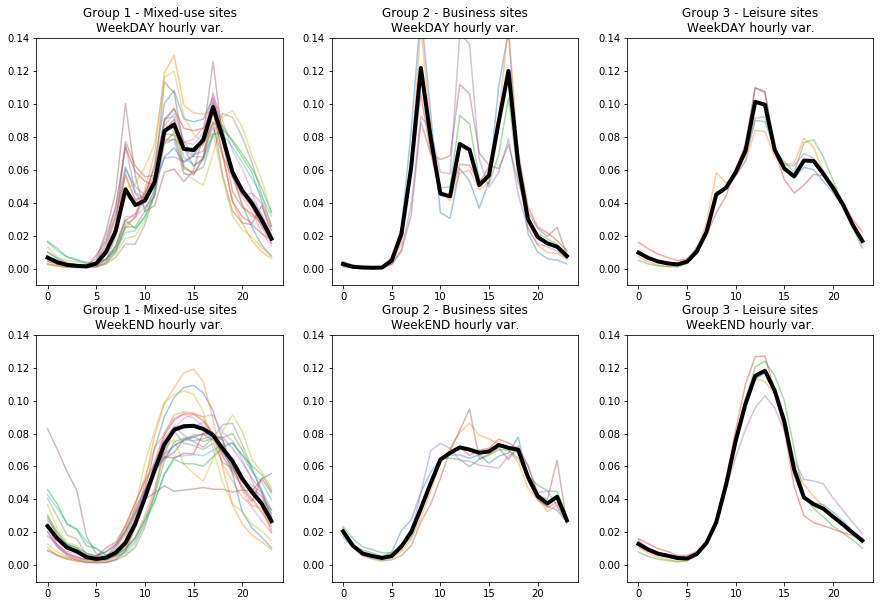

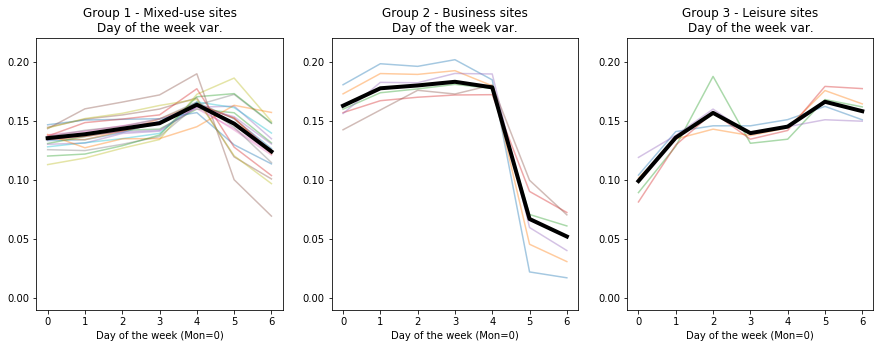

In [40]:
# Plot normalized hourly variation data
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15,10))
for i, ax in zip(range(len(hour_data_list)), axes.flat):
    ax.plot(hour_data_list[i][0], alpha=0.4)
    ax.plot(hour_data_list[i][1], linewidth=4, c='black')    
    ax.set_ylim(-0.01,0.14)
    wkday = 'WeekDAY' if len(hour_data_list[i][3]) > 2 else 'WeekEND'
    grp = hour_data_list[i][2]
    ax.set_title(f'Group {grp} - {group_name[grp]}\n{wkday} hourly var.')

# Plot normalized day of the week variation data
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,5))
for i, ax in zip(range(len(day_data_list)), axes.flat):
    ax.plot(day_data_list[i][0], alpha=0.4)
    ax.plot(day_data_list[i][1], linewidth=4, c='black')    
    ax.set_ylim(-0.01,0.22)
    ax.set_xlabel('Day of the week (Mon=0)')
    grp = hour_data_list[i][2]
    ax.set_title(f'Group {grp} - {group_name[grp]}\nDay of the week var.')
plt.show()

In [41]:
# Aggregate similar sites together using group mean
# to formulate models by group instead of by invidual site.
# Mean is chosen in order to give more weight to sites with higher traffic.

dfs = df.copy()
dfs = dfs[['date_time', 'hourly_counts', 'group']]
dfs = pd.pivot_table(dfs, values='hourly_counts', index='date_time',
                     columns='group', aggfunc=np.mean)
dfs = dfs + 1 # for log transform
dfs.head(3)

group,1,2,3
date_time,,,
2018-01-01 00:00:00,1614.947368,729.333333,326.8
2018-01-01 01:00:00,1692.105263,412.833333,244.2
2018-01-01 02:00:00,979.421053,229.666667,129.2


# SARIMA model

### Train-test split

In [0]:
# Set train/test time split
train_start  = pd.to_datetime('2018010100', format='%Y%m%d%H', errors='ignore')
train_end    = pd.to_datetime('2019103123', format='%Y%m%d%H', errors='ignore')
test_start   = pd.to_datetime('2019110100', format='%Y%m%d%H', errors='ignore')

# Assign train/test data frames
dfs_train = dfs.loc[:train_end]
dfs_test  = dfs.loc[test_start:]

### Data decomposition

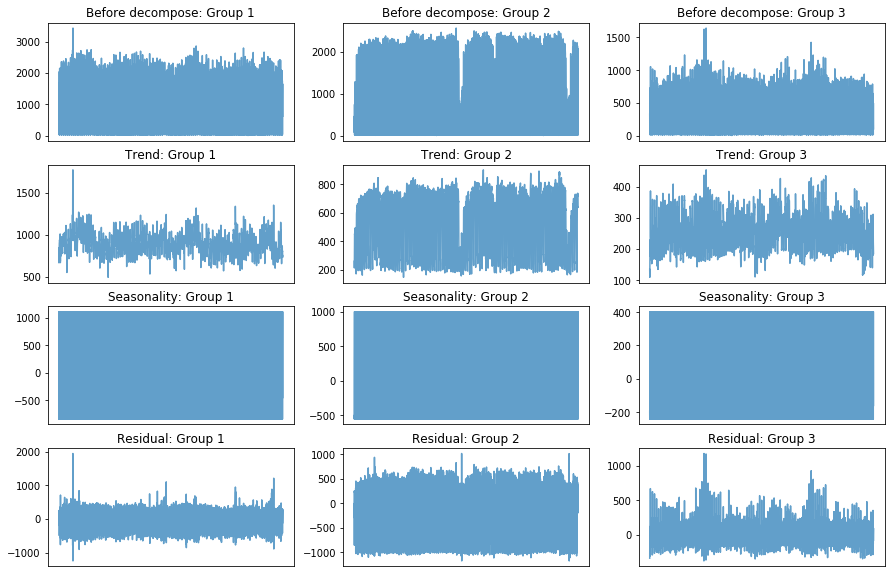

In [43]:
# Time series data composition per group
from statsmodels.tsa.seasonal import seasonal_decompose
groups = [1,2,3]
def decomp_list(dfs, groups):
  decomp, titles = [], []
  for group in groups:
    data = dfs[group]
    d    = seasonal_decompose(data,model='additive')
    decomp.append(data)
    titles.append(f'Before decompose: Group {group}')
    decomp.append(d.trend)
    titles.append(f'Trend: Group {group}')
    decomp.append(d.seasonal)
    titles.append(f'Seasonality: Group {group}')
    decomp.append(d.resid)
    titles.append(f'Residual: Group {group}')
  return decomp, titles

decomp, titles = decomp_list(dfs, groups)
order = {0:0, 1:4, 2:8, 3:1, 4:5, 5:9, 6:2, 7:6, 8:10, 9:3, 10:7, 11:11}
fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(15,10))
for n, ax in zip(range(12), axes.flat):
  ax.plot(decomp[order[n]], alpha=0.7)
  ax.set_title(titles[order[n]], fontsize=12)
  ax.set_xticks([])
plt.show()

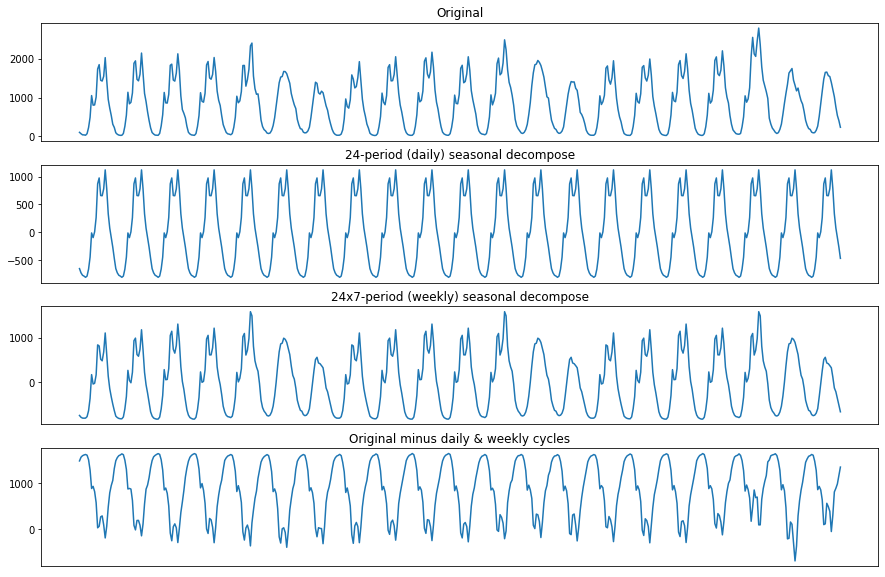

In [44]:
# Analyse daily and weekly seasonal cycles for Group 1
sample_start = pd.to_datetime('2019090200', format='%Y%m%d%H', errors='ignore') # Mon midnight
sample_end   = sample_start + pd.Timedelta(days=7*3) - pd.Timedelta(hours=1)   # Sun 11pm + 2wks

from statsmodels.tsa.seasonal import seasonal_decompose
data   = dfs[1][sample_start:sample_end]
daily  = seasonal_decompose(data, model='additive', freq=24)
weekly = seasonal_decompose(data, model='additive', freq=24*7)
adjusted = data - daily.seasonal - weekly.seasonal

fig, axes = plt.subplots(ncols=1, nrows=4, figsize=(15,10))
axes[0].plot(data)
axes[1].plot(daily.seasonal)
axes[2].plot(weekly.seasonal)
axes[3].plot(adjusted)

titles = ['Original', '24-period (daily) seasonal decompose',
          '24x7-period (weekly) seasonal decompose', 'Original minus daily & weekly cycles']
for title, ax in zip(titles, axes.flat):
  ax.set_title(title)
  ax.set_xticks([])
plt.show()

### Stationarity of time series data

In [45]:
# Calculate p-value of stationarity test over 2-year period

from statsmodels.tsa.stattools import adfuller
print(f'Verify stationarity using Dickey-Fuller test (p-value < 0.05):')
for group in groups:
  print(f'p-value for Group {group}: {adfuller(dfs_train[group])[1]}')

Verify stationarity using Dickey-Fuller test (p-value < 0.05):
p-value for Group 1: 2.006157648428943e-24
p-value for Group 2: 0.0
p-value for Group 3: 1.0497504651978425e-29


In [46]:
# Although Dickey-Fuller test result confirms stationarity over 2-year period,
# there is some dipping trend for Group 2 at the end of each year.
# This is related to low traffic in office areas during Xmas/New Year.
# We'll investigate the effect of log transforming the data:
dfs_train_log = np.log10(dfs_train)

# Recalculate p-value of stationarity test, now for log transformed data
print(f'Verify stationarity using Dickey-Fuller test for log data (p-value < 0.05):')
for group in groups:
  print(f'p-value for Group {group}: {adfuller(dfs_train_log[group])[1]}')

Verify stationarity using Dickey-Fuller test for log data (p-value < 0.05):
p-value for Group 1: 4.4435664418527563e-26
p-value for Group 2: 1.781476595857613e-29
p-value for Group 3: 1.2414493672454666e-28


### Seasional differencing

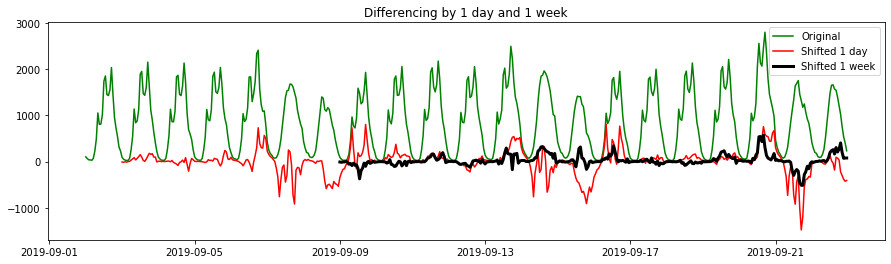

In [47]:
# Sifference data by a day and by a week for Group 1
data = dfs[1][sample_start:sample_end]
data_shift_day  = data - data.shift(24)
data_shift_week = data - data.shift(24*7)
fig, ax = plt.subplots(figsize=(15,4))
plt.plot(data, c='green', label='Original')
plt.plot(data_shift_day,  c='red', label='Shifted 1 day')
plt.plot(data_shift_week, c='black', lw=3, label='Shifted 1 week')
ax.set_title('Differencing by 1 day and 1 week')
plt.legend()
plt.show()

### Autocorrelation (ACF) & Partial Autocorrelation (PACF)

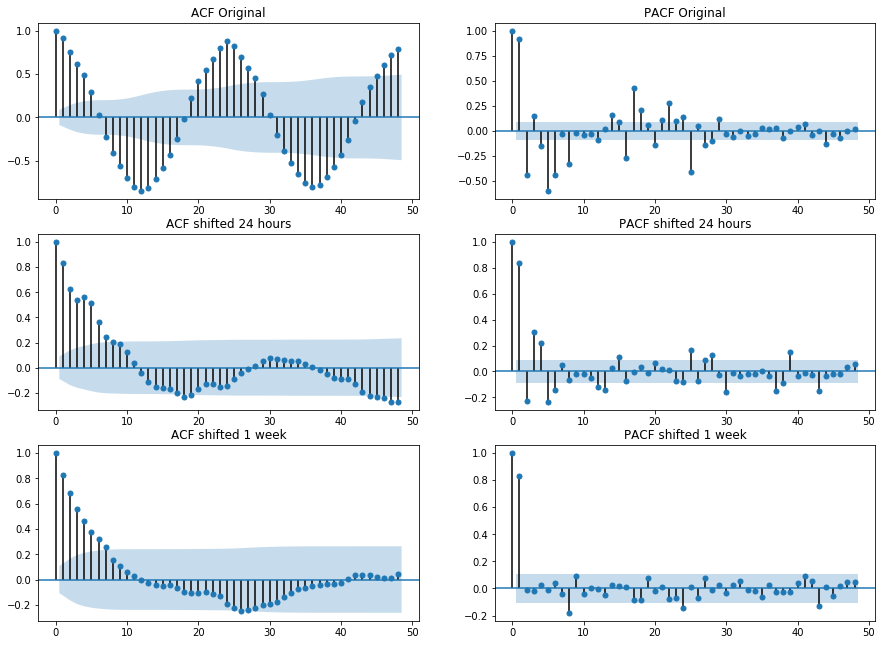

In [50]:
# Zoom in lags over 2 days
lags = 24*2

# Adjust time window since shifted data has null values at the start
data_shift_day_p  = data_shift_day[sample_start + pd.Timedelta(hours=24):]
data_shift_week_p = data_shift_week[sample_start + pd.Timedelta(hours=7*24):]

# Plot ACF & PCF
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(15,11))
plot_acf (data, lags=lags, ax=axes.flat[0], title='ACF Original')
plot_pacf(data, lags=lags, ax=axes.flat[1], title='PACF Original')
plot_acf (data_shift_day_p, lags=lags, ax=axes.flat[2], title='ACF shifted 24 hours')
plot_pacf(data_shift_day_p, lags=lags, ax=axes.flat[3], title='PACF shifted 24 hours')
plot_acf (data_shift_week_p, lags=lags, ax=axes.flat[4], title='ACF shifted 1 week')
plot_pacf(data_shift_week_p, lags=lags, ax=axes.flat[5], title='PACF shifted 1 week');

In [0]:
# ACF and PACF : view lags over 2 weeks
# lags = 24*13

# fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(15,11))
# plot_acf (data, lags=lags, ax=axes.flat[0], title='ACF Original')
# plot_pacf(data, lags=lags, ax=axes.flat[1], title='PACF Original')
# plot_acf (data_shift_day1, lags=lags, ax=axes.flat[2], title='ACF shifted 1 day')
# plot_pacf(data_shift_day1, lags=lags, ax=axes.flat[3], title='PACF shifted 1 day')
# plot_acf (data_shift_week1, lags=lags, ax=axes.flat[4], title='ACF shifted 1 week')
# plot_pacf(data_shift_week1, lags=lags, ax=axes.flat[5], title='PACF shifted 1 week');

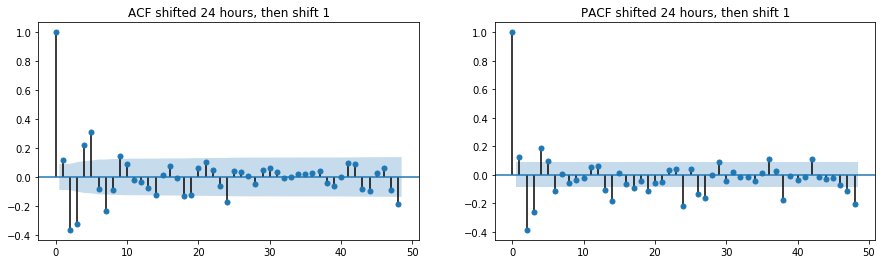

In [52]:
# Now shift the 24-hour shift by 1 since ACF is not decaying fast
data_shift_day1   = data_shift_day - data_shift_day.shift(1)
data_shift_day_p  = data_shift_day1[sample_start + pd.Timedelta(hours=24+1):]

# Replot ACF & PCF
fig, axes = plt.subplots(ncols=2, figsize=(15,4))
plot_acf (data_shift_day_p, lags=lags, ax=axes.flat[0], title='ACF shifted 24 hours, then shift 1')
plot_pacf(data_shift_day_p, lags=lags, ax=axes.flat[1], title='PACF shifted 24 hours, then shift 1');

In [0]:
# Determine baseline SARIMA parameters from the latest ACF & PACF
# (24-hour shift, then 1 more shift)

p = 6  # lag from PACF
d = 1  # non-seasonal differences taken to get stationarity
q = 7  # lag from ACF
m = 24 # cycle repeats after 24 hours
P = 2  # 2 if in PACF 24 & 48 are significant
D = 1  # follows d
Q = 2  # 2 if in ACF 24 & 48 are significant

### Run baseline SARIMA model

In [57]:
# Use parameters from baseline values above
num_of_wks = 6
one_week = pd.Timedelta(hours=7*24)
data_arima = dfs[1][train_start : train_start + one_week * num_of_wks]

start = time.time()
print(f'Start: {(datetime.utcfromtimestamp(start).strftime("%H:%M:%S"))}')

model = SARIMAX(data_arima, order=(p, d, q),
                seasonal_order=(P, D, Q, m))
output = model.fit()
summary = output.summary()     
print(f'End: {datetime.utcfromtimestamp(time.time()).strftime("%H:%M:%S")} in {round((time.time()-start)/60,1)} minutes')
display(summary)

Start: 19:03:30
End: 19:10:05 in 6.6 minutes


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  1   No. Observations:                 1009
Model:             SARIMAX(6, 1, 7)x(2, 1, 2, 24)   Log Likelihood               -5987.824
Date:                            Fri, 21 Feb 2020   AIC                          12011.648
Time:                                    19:10:05   BIC                          12099.697
Sample:                                01-01-2018   HQIC                         12045.139
                                     - 02-12-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3846      0.155      2.480      0.013       0.081       0.688
ar.L2         -0.3679      0.111     -3.313      0.001      -0.585      -0.150
ar.L3         -0.2467      0.054     -4.587      0.000      -0.352      -0.141
ar.L4          0.5730      0.065      8.834      0.000       0.446       0.700
ar.L5         -0.4679      0.112     -4.188      0.000      -0.687      -0.249
ar.L6          0.4021      0.098      4.121      0.000       0.211       0.593
ma.L1         -0.3410      0.557     -0.612      0.540      -1.433       0.751
ma.L2          0.1700      0.378      0.449      0.653      -0.572       0.912
ma.L3          0.1000      0.457      0.219      0.827      -0.795       0.995
ma.L4         -0.5227      0.506     -1.033      0.301      -1.514       0.469
ma.L5          0.4395      0.240      1.830      0.067      -0.031       0.910
ma.L6         -0.6449      0.466     -1.384      0.166      -1.558       0.269
ma.L7         -0.2008      0.144     -1.399      0.162      -0.482       0.080
ar.S.L24       0.9825      0.073     13.435      0.000       0.839       1.126
ar.S.L48      -0.5437      0.049    -11.128      0.000      -0.639      -0.448
ma.S.L24      -1.4601      0.089    -16.484      0.000      -1.634      -1.286
ma.S.L48       0.5603      0.084      6.655      0.000       0.395       0.725
sigma2      1.475e+04   7968.407      1.852      0.064    -863.056    3.04e+04
===================================================================================
Ljung-Box (Q):                       49.43   Jarque-Bera (JB):               187.58
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [0]:
# Test save pickle
filename = 'pickle_baseline.sav'
pickle.dump(output, open(filename, 'wb'))
# Test open pickle
filename = 'pickle_baseline.sav'
baseline = pickle.load(open(filename, 'rb'))

In [65]:
# Optimize hyperparameters
num_of_wks = 2 # CHECK THIS ALSO
data_arima = dfs[1][train_start : train_start + one_week * num_of_wks] # CHECK THIS B4 RUNNING
sample_size = len(data_arima)

start = time.time()
print(f'Start: {(datetime.utcfromtimestamp(start).strftime("%H:%M:%S"))}')

# Hyperparameter list to test
p_list = [6,7]
q_list = [6]
P_list = [1]
Q_list = [1]
d, D, m = 1, 1, 24
results = []

# Iterate through list to train SARIMA model
for p in p_list:
  for q in q_list:
    try:
      model = SARIMAX(data_arima, order=(p, d, q), seasonal_order=(P, D, Q, m)).fit()
    except:
      continue
    aic = model.aic
    if aic < float("inf"): # if fail to converge
      best_model = model
      best_aic = aic
    results.append([p, d, q, P, D, Q, m, sample_size, round(model.aic,0)])

  result_table = pd.DataFrame(results)
  result_table.columns = ['p','d','q','P','D','Q','m','samples','aic']
  result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
  
print(f'End: {datetime.utcfromtimestamp(time.time()).strftime("%H:%M:%S")} in {round((time.time()-start)/60,1)} minutes')
result_table

Start: 19:33:29
End: 19:37:44 in 4.2 minutes


,p,d,q,P,D,Q,m,samples,aic
0,6,1,6,2,1,2,24,337,3857.011679
1,7,1,6,2,1,2,24,337,3859.780371


In [66]:
# Save result table in pickle
filename = 'pickle_baseline_optimization.sav'
pickle.dump(result_table, open(filename, 'wb'))
# Test open pickle
filename = 'pickle_baseline_optimization.sav'
baseline_hyperparams = pickle.load(open(filename, 'rb'))
baseline_hyperparams

,p,d,q,P,D,Q,m,samples,aic
0,6,1,6,2,1,2,24,337,3857.011679
1,7,1,6,2,1,2,24,337,3859.780371


In [0]:
# # PLOT PREDICTION
# # adding model values
# data = series.copy()
# data.columns = ['actual']
# data['arima_model'] = model.fittedvalues
# # making a shift on s+d steps, because these values were unobserved by the model
# # due to the differentiating
# data['arima_model'][:s+d] = np.NaN

# # forecasting on n_steps forward 
# forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
# forecast = data.arima_model.append(forecast)
# # calculate error, again having shifted on s+d steps from the beginning
# error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

# plt.figure(figsize=(15, 7))
# plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
# plt.plot(forecast, color='r', label="model")
# plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
# plt.plot(data.actual, label="actual")
# plt.legend()
# plt.grid(True);

In [0]:
# # Reference SARIMA parameters from notes
# p = 4  # lag from PACF
# d = 1  # non-seasonal differences to get stationarity
# q = 4  # lag from ACF
# m = 24 # cycle repeats after 24 hours
# P = 2  # PACF: 24 & 48 are significant
# D = 1  # seasonal difference
# Q = 1  # ACF: 24 is significant but 48 is not

# num_of_wks = 6
# one_week = pd.Timedelta(hours=7*24)
# data_arima = dfs[1][train_start : train_start + one_week * num_of_wks]

# start = time.time()
# print(f'Start: {(datetime.utcfromtimestamp(start).strftime("%H:%M:%S"))}')

# from statsmodels.tsa.statespace.sarimax import SARIMAX
# model = SARIMAX(data_arima, order=(p, d, q),
#                 seasonal_order=(P, D, Q, m))
# output = model.fit()
# summary = output.summary()     
# print(f'End: {datetime.utcfromtimestamp(time.time()).strftime("%H:%M:%S")} in {round((time.time()-start)/60,1)} minutes')
# display(summary)

In [0]:
# def objfunc(order, exog, endog):
#     from statsmodels.tsa.arima_model import ARIMA
#     fit = ARIMA(endog, order, exog).fit()
#     return fit.aic()

# from scipy.optimize import brute
# grid = (slice(1, 3, 1), slice(1, 3, 1), slice(1, 3, 1))
# brute(objfunc, grid, args=(exog, endog), finish=None)

In [0]:
# also see
# statsmodels.tsa.arima_model.ARIMAResults # obtain p-value
# statsmodels.tsa.arima_model.ARIMAResults.predict # to cross-validate alternative models

# To do list

~~EDA~~
1. ~~Narrow down sites and period~~
2. ~~Variation by high/low traffic sites~~
3. ~~Variation by hour / day of week / seasons~~

~~Cleansing~~
1. ~~Verify no missing timestamp~~
2. ~~Fill nulls based on general variation rule~~

~~Assign sites to groups~~
1. ~~Run PCA to get better insight on possible groupings~~
2. ~~Combine PCA with EDA info to decide on groupings~~
3. ~~Drop more sites if needed / restate outliers if needed~~

Stinky model - SARIMA
1. ~~Train/test split~~
2. ~~Stationarity~~
3. ~~Differencing~~
4. ~~PACF, ACF~~
5. ~~Select p, d, q~~
6. ~~Select P, D, Q, m seasonality~~
7. Optimize all parameters
8. Calculate error
9. 

Enhanced models
1. RNN
2. LSTM

Visualisation for end users
1. Static heatmap on city centre map
2. Variable heatmap animation
3. Variable hourly plot animation
4. Web app
